# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

## Общая информация

Дата выдачи: 13.12.2022

Мягкий дедлайн: 20.12.2022 23:59 MSK

Жёсткий дедлайн: 20.12.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

from boosting import MyDecisionTree, DecisionTreeRegressor, RandomForest, GradientBoosting

sns.set(style='darkgrid')
filterwarnings('ignore')

Сначала построим и протестируем одно решающее дерево

In [2]:
X, y = datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

Константная модель

In [3]:
mean_squared_error(y_test, np.full(len(y_test), y_test.mean()))

5127.9270294154785

Дерево глубины 5 из sklearn

In [4]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test))

4669.900912391118

Протестируем наше дерево и обучим его

In [5]:
# Check if zero error is possible
mean_squared_error(DecisionTreeRegressor().fit(X_train, y_train).predict(X_train), y_train)

0.0

In [6]:
assert MyDecisionTree(loss="mse").fit(X_train, y_train).eval(X_train, y_train) == 0.0, "Fix the bugs pls"
model = MyDecisionTree(loss="mse", max_depth=3)
model.fit(X_train, y_train)
model.eval(X_test, y_test)

4764.48500468469

Проверим работу обработки категориальных признаков

In [7]:
xcat = np.expand_dims(np.array([1, 1, 2, 1, 2, 3, 3]), axis=1)
ycat = np.array([10, 10, 20, 10, 20, 30, 30])
assert MyDecisionTree(feature_types=["cat"]).fit(xcat, ycat).eval(xcat, ycat) == 0

Базовая модель готова!

Построим же Бэггинг!

In [8]:
# sklearn random forest
bagging = RandomForestRegressor(n_estimators=50)
bagging.fit(X_train, y_train)
mean_squared_error(bagging.predict(X_test), y_test)

3843.2032134831456

In [9]:
# my random forest
bagging = RandomForest(n_estimators=50, base_model_params={"loss": "mse"})
bagging.fit(X_train, y_train)
bagging.eval(X_test, y_test)

3618.8406267166038

Да прибудет с нами градиентный бустинг!

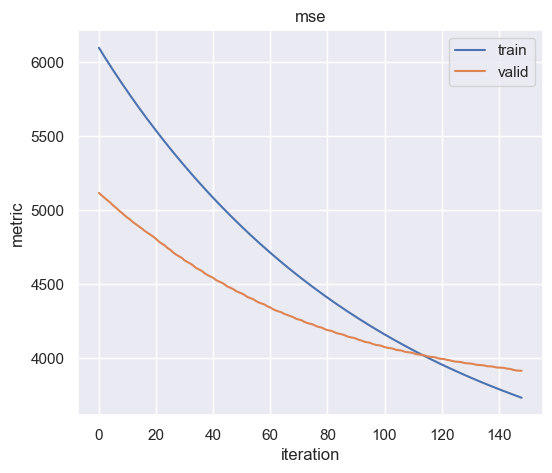

3915.3934709330097

In [12]:
boosting = GradientBoosting(
    loss_type="mse",
    n_estimators=150,
    plot=True,
    learning_rate=0.004,
    base_model_params={"loss": "mse", "max_depth": 2}
)
boosting.fit(X_train, y_train, X_valid=X_test, y_valid=y_test)
boosting.eval(X_test, y_test)

In [13]:
x = load_npz('x.npz').toarray()
y = np.load('y.npy')
y[:5]

array([ 1,  1, -1,  1, -1])

In [14]:
y[y == -1] += 1
y[:5]

array([1, 1, 0, 1, 0])

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

### Проверка кода

У автора задания всё учится около одной секунды.

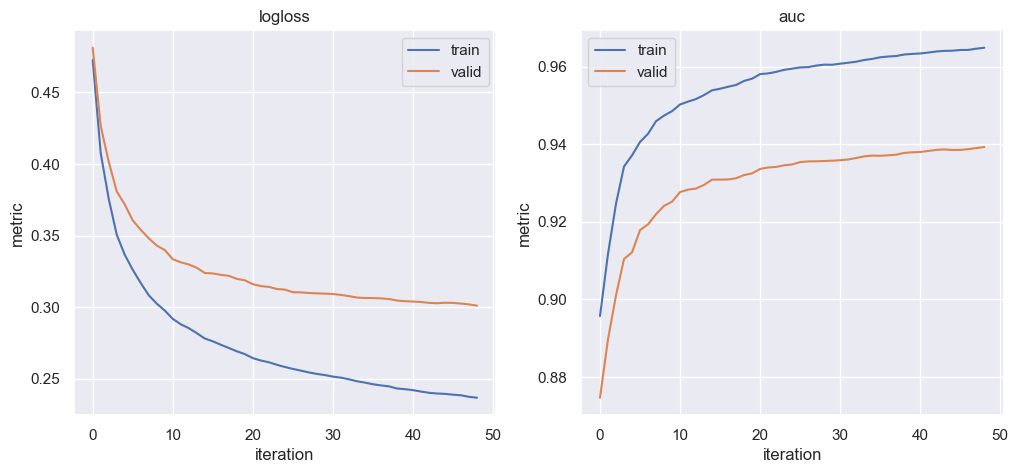

Train ROC-AUC 0.9649
Valid ROC-AUC 0.9393
Test ROC-AUC 0.9351


In [16]:
boosting = GradientBoosting(loss_type="logloss", learning_rate=2, n_estimators=50, subsample=0.3, base_model_params={"max_depth": 3}, plot=True)

boosting.fit(x_train, y_train, x_valid, y_valid, eval_metrics=["auc"])

assert len(boosting.models) == boosting.n_estimators

print(f'Train ROC-AUC {roc_auc_score(y_train, boosting.predict(x_train)):.4f}')
print(f'Valid ROC-AUC {roc_auc_score(y_valid, boosting.predict(x_valid)):.4f}')
print(f'Test ROC-AUC {roc_auc_score(y_test, boosting.predict(x_test)):.4f}')

## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [17]:
results = {}

depths = range(1, 30, 2)

# YOUR CODE:

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

`### ваше решение тут ###`

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [18]:
# YOUR CODE:

## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

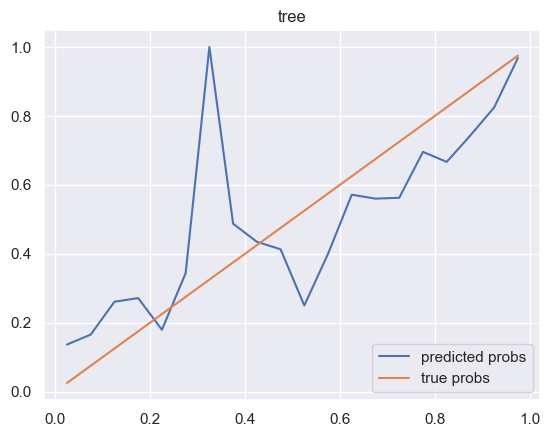

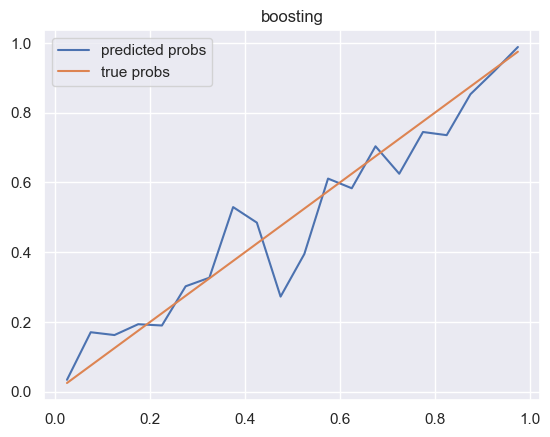

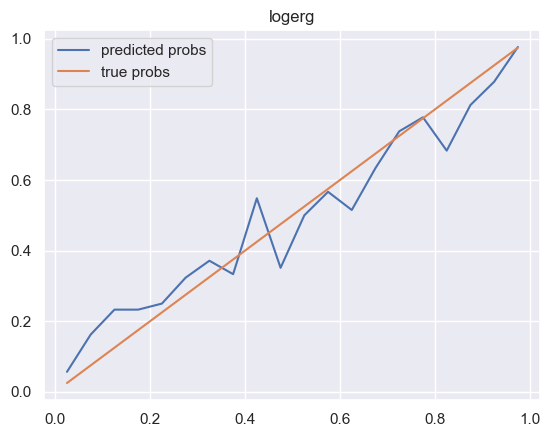

In [23]:
def plot_calibration_curve(model, X, y, n_bins=20, title=""):
    preds = model.predict_proba(X)[:, 1]
    true_probs = []
    predicted_probs = []
    for i in range(n_bins):
        bin_left = 1. * i / n_bins
        bin_right = 1. * (i + 1) / n_bins
        filtration = y[(preds >= bin_left) & (preds < bin_right)]  # доля объектов каждого класса с заданной вероятностью примерно равна вероятности

        true_probs.append((bin_left + bin_right) / 2)
        predicted_probs.append(filtration.mean())
    plt.plot(true_probs, predicted_probs, label = "predicted probs")
    plt.plot(true_probs, true_probs, label = "true probs")
    plt.title(title)
    plt.legend()
    plt.show()

tree_model = DecisionTreeClassifier(max_depth=10, random_state=0).fit(x_train, y_train)
plot_calibration_curve(tree_model, x_test, y_test, title="tree")

plot_calibration_curve(boosting, x_test, y_test, title="boosting")

logreg_model = LogisticRegression(random_state=0).fit(x_train, y_train)
plot_calibration_curve(logreg_model, x_test, y_test, title="logerg")

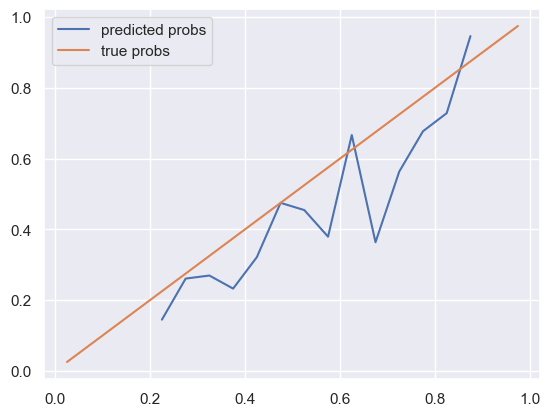

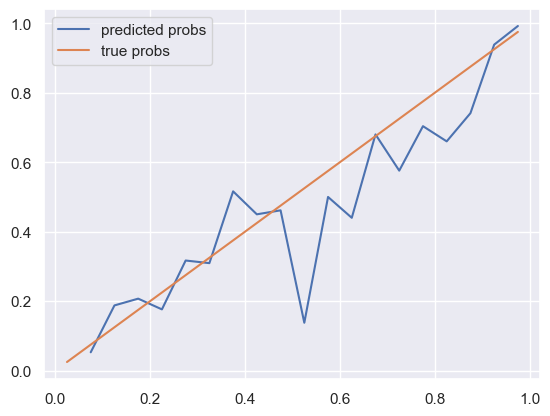

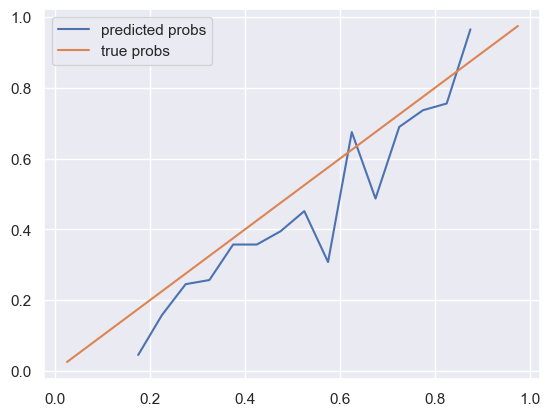

In [25]:
class PlattSigmoidCalibrator:
    def __init__(self, model, **kwargs):
        self.model = model
        self.calibrator = LogisticRegression(**kwargs)

    def fit(self, x_val, y_val):
        preds = np.expand_dims(self.model.predict_proba(x_val)[:, 1], 1)
        self.calibrator.fit(preds, y_val)
        return self

    def predict(self, x):
        preds = np.expand_dims(self.model.predict_proba(x)[:, 1], 1)
        return self.calibrator.predict(preds)

    def predict_proba(self, x):
        preds = np.expand_dims(self.model.predict_proba(x)[:, 1], 1)
        return self.calibrator.predict_proba(preds)

calibrated_tree = PlattSigmoidCalibrator(tree_model, C=0.05).fit(x_valid, y_valid)
plot_calibration_curve(calibrated_tree, x_test, y_test)

calibrated_boosting = PlattSigmoidCalibrator(boosting, C=0.05).fit(x_valid, y_valid)
plot_calibration_curve(calibrated_boosting, x_test, y_test)

calibrated_logreg = PlattSigmoidCalibrator(logreg_model, C=0.05).fit(x_valid, y_valid)
plot_calibration_curve(calibrated_logreg, x_test, y_test)

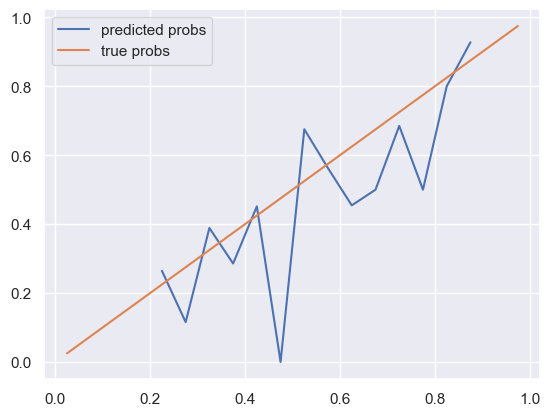

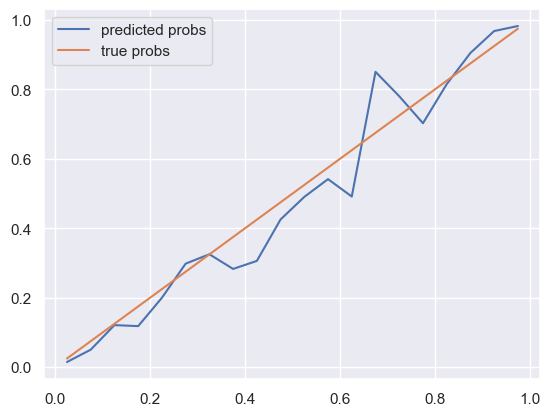

In [85]:
calibrated_tree = CalibratedClassifierCV(tree_model, cv=2).fit(x_valid, y_valid)
plot_calibration_curve(calibrated_tree, x_test, y_test)

calibrated_logreg = CalibratedClassifierCV(logreg_model, cv=2).fit(x_valid, y_valid)
plot_calibration_curve(calibrated_logreg, x_test, y_test)

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

In [ ]:
# YOUR CODE:

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
# YOUR CODE:

## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
# YOUR CODE:

## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
# YOUR CODE:

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2023 года?